# Purpose of this code

In [ ]:
## Install calibration package
!pip install git+https://github.com/uu-sml/calibration.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/uu-sml/calibration.git to /tmp/pip-req-build-9j36v_tw
  Running command git clone -q https://github.com/uu-sml/calibration.git /tmp/pip-req-build-9j36v_tw


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import os
import shutil
import time

from sklearn import metrics
from sklearn import calibration
from scipy import stats as sp_stats

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

El paquete de _calibration_ tal cual como viene de github, no trae la carpeta de _utils_ donde están las distancias que se pueden utilizar. Adicionalmente, la inicialización del paquete no contiene nada, por lo cual se debe solucionar este problema con los siguientes.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Path in where files to fix clone of calibration module are
path_in = "/content/drive/MyDrive/Trabajo de Grado Maestría/Librería Calibration/"

## Path out where files to fix clone of calibration module have to be
path_out = "/usr/local/lib/python3.7/dist-packages/calibration/"

## Create folder
if not os.path.isdir(path_out + "utils"):
  os.mkdir(path_out + "utils")

## Copy files
shutil.copyfile(path_in + "distances.py", path_out + "utils/distances.py")
shutil.copyfile(path_in + "__init__.py", path_out + "utils/__init__.py")

'/usr/local/lib/python3.7/dist-packages/calibration/utils/__init__.py'

In [ ]:
## Calibration functions
import calibration.stats as cali_stats
import calibration.utils as cali_utils
import calibration.binning as cali_binning
import calibration.sample as cali_sample
import calibration.lenses as cali_lenses

## Other functions

In [ ]:
# #===========================================================#
# #     Function to obtain probabilities from SVM model       #
# #===========================================================#
from scipy.special import softmax

def proba_svm(X, model):
  # pred = model.decision_function(X)
  # pred = (pred - pred.min())/(pred.max() - pred.min())
  # pred = np.concatenate((1-pred.reshape(-1,1), pred.reshape(-1,1)), axis = 1)
  dec = model.decision_function(X)

  if len(dec.shape) == 1:
    pred = 1/(1 + np.exp(-dec))
    pred = np.concatenate((1-pred.reshape(-1,1), pred.reshape(-1,1)), axis = 1)
    return pred
  else:
    pred = softmax(dec, axis = 1)
    return pred

## Cleansing functions

In [ ]:
# One hot categorical variables
def getCatVariables(df, nom_cat):
  """
  Function to get one hot encoding for categorical variables based on the names
  in the dataframe.

  Return numpy array
  """
  c = 0
  if len(nom_cat) > 0:
    for i in nom_cat:
      if c == 0:
        if np.unique(df[i]).shape[0] == 2:
          X_cat = df[i].to_numpy().reshape(-1,1)
        else:
          X_cat = pd.get_dummies(df[i]).values
        c += 1
      else:
        if np.unique(df[i]).shape[0] == 2:
          X_cat = np.concatenate((X_cat, df[i].to_numpy().reshape(-1,1)), axis = 1)
        else:
          X_cat = np.concatenate((X_cat, pd.get_dummies(df[i]).values) , axis = 1)
          c += 1
  else:
    X_cat = None
  return X_cat

# Combine numerical variables
def getNumVariables(df, nom_num):
  """
  Function to get the numerical variables based on the names in the dataframe.

  Return numpy array
  """
  c = 0
  if len(nom_num) > 0:
    for i in nom_num:
      if c == 0:
        X_num = pd.to_numeric(df[i]).to_numpy().reshape(-1,1)
        c += 1
      else:
        X_num = np.concatenate((X_num, pd.to_numeric(df[i]).to_numpy().reshape(-1,1)), axis = 1)
        c += 1
  else:
    X_num = None

  return X_num

## Calibration functions

In [ ]:
#===================================#
#     Class-wise ECE for tensors    #
#===================================#
def cwECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = 0.0

  ## Calculate ECE for each class
  for k in range(y_pred.shape[1]):
    ## Store probs and observations
    confidences = y_pred[:,k]
    accuracies = y_pred[:,k] == 1

    ece = 0.0
    # ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
      prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

      if prop_in_bin > 0:
          accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
          avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
          ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    ## Store values
    ece_list += ece

  ece_list = ece_list/y_pred.shape[1]

  return ece_list

#========================================#
#   Maximum confidence ECE for tensors   #
#========================================#
def maxECE_tf(y_true, y_pred):
  n_bins = 15

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = tf.math.reduce_max(y_pred, axis = 1)
  predictions = tf.math.argmax(y_pred, axis = 1)
  accuracies = predictions == tf.math.argmax(y_true, axis = 1)

  ## Confidence and predictions in each bin
  ece = 0.0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
    prop_in_bin = tf.reduce_mean(tf.cast(in_bin, tf.float32))

    if prop_in_bin > 0:
        accuracy_in_bin = tf.reduce_mean(tf.cast(accuracies[in_bin], tf.float32))
        avg_confidence_in_bin = tf.reduce_mean(tf.cast(confidences[in_bin], tf.float32))
        ece += tf.math.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

  return ece

#================================#
#          Class-wise ECE        #
#================================#
def cwECE(n_bins, probs, obs, metric):
  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## List to store the ECE for each class
  ece_list = []

  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Calculate ECE for each class
  for k in range(probs.shape[1]):

    ## Store probs and observations
    confidences = probs[:,k]
    accuracies = obs[:,k] == 1

    ## Lists to store values to plot the reliability diagram
    conf = []
    acc = []
    bin = []

    ece = 0
    ## Iterate over each bin Bij
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
      bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
      in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
      prop_in_bin = np.mean(in_bin)
      if prop_in_bin > 0:
        accuracy_in_bin = np.mean(accuracies[in_bin])
        avg_confidence_in_bin = np.mean(confidences[in_bin])
        ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        conf += [avg_confidence_in_bin]
        acc += [accuracy_in_bin]
        bin += [(bin_lower + bin_upper)/2]
        del in_bin, prop_in_bin, accuracy_in_bin, avg_confidence_in_bin
    ## Store values
    conf_list += [conf]
    acc_list += [acc]
    bin_list += [bin]
    ece_list += [ece]
    del conf, acc, bin, ece

  if metric is True:
    return np.mean(ece_list)
  else:
    return ece_list, conf_list, acc_list, bin_list

#================================#
#    Maximum confidence ECE      #
#================================#
def maxECE(n_bins, probs, obs, metric):
  ## Lists to store values to plot the reliability diagram
  conf_list = []
  acc_list = []
  bin_list = []

  ## Bins partitions
  bin_boundaries = np.linspace(0, 1, n_bins + 1)
  bin_lowers = bin_boundaries[:-1]
  bin_uppers = bin_boundaries[1:]

  ## Confidence and predictions
  confidences = probs.max(axis = 1)
  predictions = probs.argmax(axis = 1)
  accuracies = probs.argmax(axis = 1) == obs.argmax(axis = 1)

  ## Confidence and predictions in each bin
  ece = 0
  for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    bin_lower = np.where(bin_lower == 0, -0.000000001, bin_lower).tolist()
    in_bin = (confidences > bin_lower)*(confidences <= bin_upper)
    prop_in_bin = np.mean(in_bin)

    if prop_in_bin > 0:
      accuracy_in_bin = np.mean(accuracies[in_bin])
      avg_confidence_in_bin = np.mean(confidences[in_bin])
      ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
      conf_list += [avg_confidence_in_bin]
      acc_list += [accuracy_in_bin]
      bin_list += [(bin_lower + bin_upper)/2]

  if metric is True:
    return ece
  else:
    return ece, conf_list, acc_list, bin_list

#========================#
#   Brier multiclass     #
#========================#
def brier_multi(targets, probs):
  """
  targets: Numpy array of one-hot encoding of observed labels with shape (n, classes)
  probs: Numpy array of probs for each class with shape (n, classes)
  """
  return np.mean(np.sum((probs - targets)**2, axis = 1))

#================================================#
#   Function to calculate calibration metrics    #
#================================================#
def resume_metrics(X_test, Y_test, T_test, model, nbins, p_value, proba):
  """
  Arguments:
    X_test    : Covariates for testing (n,p)
    Y_test    : Target variable dimension for testing (n,)
    T_test    : One hot encoding of the target variable dimension for testing (n,c)
    p_value   : Whether it should be done the resampling to obtain the p-value of ece metrics

    model     : Model object that contains .predict function to obtain the probabilities for each class
    nbins     : Number of equally sized bins created
    p_value   : Wheter calculate the ECE metrics p-value
    proba     : Wheter model object has predict_proba class to obtain probabilities

  where:
    c: Number of classes
    p: number of covariates
    n: Number of observations

  It returns a tuple with pandas data.frames with results of calibration metrics
  """

  #==============================================#
  #                 Organize data                #
  #==============================================#
  ## Predictions on test
  if proba == "predict_proba":
    pred_test = model.predict_proba(X_test)
  elif proba == "predict":
    pred_test = model.predict(X_test)
  elif proba == "svm":
    pred_test = proba_svm(X_test, model)
  else:
    return "Invalid 'proba' argument"

  ## Most confident probability predictions (Maximum lenses)
  pred_test_max, T_test_max = cali_lenses.maximum_lens(probs = pred_test, y = T_test)

  #=============================================================================#
  #                  Expected Calibration Error                                 #
  #=============================================================================#
  ## Cambiar nombres
  ## ECE + dependent binning + tvdistance
  ece_max_uni = cali_stats.ece(probs = pred_test_max,
                              y = T_test_max,
                              distance = cali_utils.tvdistance,
                              binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean"))

  ## ECE + uniform binning + tvdistance
  ece_max_dep = cali_stats.ece(probs = pred_test_max,
                              y = T_test_max,
                              distance = cali_utils.tvdistance,
                              binning = cali_binning.UniformBinning(bins = nbins))

  ## cwECE + uniform binning
  ece_cw_uni = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = True)

  #======================================================#
  #       Samples under perfect calibration (ECE)        #
  #======================================================#

  if p_value:
    np.random.seed(6164)
    ## ECE + dependent binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                                binning = cali_binning.DataDependentBinning(min_size = pred_test.shape[0]*0.1, threshold = "mean")),
                                n = 1000)

    # Generate samples
    ece_max_dep_sample = resample(pred_test_max)
    del resample

    ## ECE + uniform binning + tvdistance
    # Define Resampling
    resample = cali_sample.ResampleStats(
        lambda x: cali_stats.ece(probs = x, y = None, distance = cali_utils.tvdistance,
                                binning = cali_binning.UniformBinning(bins = nbins)),
                                n = 1000)

    # Generate samples
    ece_max_uni_sample = resample(pred_test_max)
    del resample

    ## cw-ECE + uniform binning
    # Define Resampling
    resample = cali_sample.ResampleStats(lambda x: cwECE(n_bins = nbins, probs = x, obs = T_test, metric = True), n = 1000)

    # Generate samples
    ece_cw_uni_sample = resample(pred_test)

    #====================================================================#
    #    P-value of ECE under assumption of perfect calibration (ECE)    #
    #====================================================================#
    ## Data dependent binning + tv distance
    p_data_max = 1 - sp_stats.percentileofscore(ece_max_dep_sample, ece_max_dep)/100

    ## Uniform binning + tv distance
    p_uni_max = 1 - sp_stats.percentileofscore(ece_max_uni_sample, ece_max_uni)/100

    ## Uniform binning + tv distance
    p_uni_cw = 1 - sp_stats.percentileofscore(ece_cw_uni_sample, ece_cw_uni)/100

  #==================================#
  #          Brier score             #
  #==================================#
  ## Brier for all classes
  bri_full = brier_multi(targets = T_test, probs = pred_test)

  ## Brier for most confidence class
  bri_max = brier_multi(targets = T_test_max, probs = pred_test_max)

  #===========================#
  #           Log Loss        #
  #===========================#
  loss_full = metrics.log_loss(y_true = T_test, y_pred = pred_test)
  loss_maxx = metrics.log_loss(y_true = T_test_max, y_pred = pred_test_max)

  #=================================================#
  #                 Reliability Diagram             #
  #=================================================#
  ## Class-wise reliability diagram and ECE individually
  cw_ece_list, cw_conf_list, cw_acc_list, cw_bin_list = cwECE(n_bins = nbins, probs = pred_test, obs = T_test, metric = False)

  ## Most confident prediction
  max_ece, max_conf_list, max_acc_list, max_bin_list = maxECE(n_bins = nbins, probs = pred_test_max, obs = T_test_max, metric = False)

  ## Organize data
  diag_cw = pd.DataFrame({"ece" : cw_ece_list, "conf" : cw_conf_list, "acc" : cw_acc_list, "bin" : cw_bin_list})
  diag_max = pd.DataFrame({"ece" : max_ece, "conf" : max_conf_list, "acc" : max_acc_list, "bin" : max_bin_list})

  #=============================#
  #   Combine all the results   #
  #=============================#
  if p_value:
    ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.mean(ece_max_dep_sample), np.mean(ece_max_uni_sample), np.mean(ece_cw_uni_sample) ],
        "ECE perfcect std" : [np.std(ece_max_dep_sample), np.std(ece_max_uni_sample), np.std(ece_cw_uni_sample) ],
        "ECE p-value" : [p_data_max, p_uni_max, p_uni_cw] })
  else:
        ## Combine results
    global_metrics_ece = pd.DataFrame({
        "Approach" : ["Maximum","Maximum","CW"],
        "Distance" : ["TV","TV","-"],
        "Binning" : ["Data","Uniform","Uniform"],
        "ECE observed" : [ece_max_dep, ece_max_uni, ece_cw_uni],
        "ECE perfcect mean" : [np.nan, np.nan, np.nan ],
        "ECE perfcect std" : [np.nan, np.nan, np.nan ],
        "ECE p-value" : [np.nan, np.nan, np.nan ] })

  global_metrics = pd.DataFrame({
      "Brier_full" : [bri_full],
      "Brier_maximum" : [bri_max],
      "Log-loss_full" : [loss_full],
      "Log-loss_maximum" : [loss_maxx] })

  return global_metrics, global_metrics_ece, diag_max, diag_cw


#=====================================================================#
#           Function to plot the results of the optimization          #
#=====================================================================#
def GraphOptimizationMetrics(df_metrics, df_metrics_ece, par_row, par_col, name_par_row, name_par_col):
  """
  This functions plot the results of global and calibration metrics output of resume_metrics.

  df_metrics: It is a pandas dataframe that corresponds to the "gm" object
  df_metrics_ece: It is a pandas dataframe that corresponds to the "gm_ece" object
  par_row: String of the name of the parameter in the tables to display in the row heatmap
  par_col: String of the name of the parameter in the tables to display in the columns heatmap
  name_par_row: String of the name of the parameter to display in the row heatmap
  name_par_col: String of the name of the parameter to display in the column heatmap

  Output a grid of plots with some of the results
  """
  ## Subset data
  ece_cw = df_metrics_ece.loc[df_metrics_ece["Approach"] == "CW",:]
  ece_max_u = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Uniform"),:]
  ece_max_d = df_metrics_ece.loc[(df_metrics_ece["Approach"] == "Maximum") & (df_metrics_ece["Binning"] == "Data"),:]

  ## Format for ticks
  majorFormatter = FormatStrFormatter('%.2f')

  ## Color map for heatmaps
  color_map = "flare_r"#"Greys_r"#"flare_r"

  if df_metrics[par_col].unique().shape[0] != 1:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss
    dd = df_metrics.pivot(par_row, par_col, "Log-loss_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                ax = axis[0,0],
                cmap = color_map,
                cbar_kws={'label': ''})

    axis[0,0].set_xlabel(name_par_col)
    axis[0,0].set_ylabel(name_par_row)
    axis[0,0].set_title("Log-loss (Validation)")
    # axis[0,0].xaxis.set_major_formatter(majorFormatter)
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    dd = df_metrics.pivot(par_row, par_col, "acc_train")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,1],
                cbar_kws={'label': ''})

    axis[0,1].set_xlabel(name_par_col)
    axis[0,1].set_ylabel(name_par_row)
    axis[0,1].set_title("Accuracy (Training)")
    #axis[0,1].xaxis.set_major_formatter(majorFormatter)
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    dd = df_metrics.pivot(par_row, par_col, "acc_val")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map.replace("_r",""),
                ax = axis[0,2],
                cbar_kws={'label': ''})

    axis[0,2].set_xlabel(name_par_col)
    axis[0,2].set_ylabel(name_par_row)
    axis[0,2].set_title("Accuracy (Validation)")
    #axis[0,2].xaxis.set_major_formatter(majorFormatter)
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    dd = df_metrics.pivot(par_row, par_col, "Brier_full")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,0],
                cbar_kws={'label': ''})

    axis[1,0].set_xlabel(name_par_col)
    axis[1,0].set_ylabel(name_par_row)
    axis[1,0].set_title("Brier Score (Validation)")
    #axis[1,0].xaxis.set_major_formatter(majorFormatter)
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    dd = ece_max_u.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,1],
                cbar_kws={'label': ''})

    axis[1,1].set_xlabel(name_par_col)
    axis[1,1].set_ylabel(name_par_row)
    axis[1,1].set_title("Max-ECE uniform\n(Validation)")
    #axis[1,1].xaxis.set_major_formatter(majorFormatter)
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    dd = ece_max_d.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,2],
                cbar_kws={'label': ''})

    axis[1,2].set_xlabel(name_par_col)
    axis[1,2].set_ylabel(name_par_row)
    axis[1,2].set_title("Max-ECE data\n(Validation)")
    #axis[1,2].xaxis.set_major_formatter(majorFormatter)
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    dd = ece_cw.pivot(par_row, par_col, "ECE observed")
    dd.columns = np.round(dd.columns,2)
    dd.index = np.round(dd.index,2)
    sns.heatmap(dd,
                cmap = color_map,
                ax = axis[1,3],
                cbar_kws={'label': ''})

    axis[1,3].set_xlabel(name_par_col)
    axis[1,3].set_ylabel(name_par_row)
    axis[1,3].set_title("CW-ECE\n(Validation)")
    #axis[1,3].xaxis.set_major_formatter(majorFormatter)
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.2)
    plt.show()
  else:
    fig, axis = plt.subplots(2, 4, figsize = (20,8))

    ##====== Log-loss
    axis[0,0].plot(df_metrics[par_row], df_metrics["Log-loss_full"], ".-", color = "#6F6F6F")
    axis[0,0].set_xlabel(name_par_row)
    axis[0,0].set_ylabel("Log-loss")
    axis[0,0].set_title("Log-loss (Validation)")
    axis[0,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy train
    axis[0,1].plot(df_metrics[par_row], df_metrics["acc_train"], ".-", color = "#6F6F6F")
    axis[0,1].set_xlabel(name_par_row)
    axis[0,1].set_ylabel("Accuracy")
    axis[0,1].set_title("Accuracy (Training)")
    axis[0,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Accuracy validation
    axis[0,2].plot(df_metrics[par_row], df_metrics["acc_val"], ".-", color = "#6F6F6F")
    axis[0,2].set_xlabel(name_par_row)
    axis[0,2].set_ylabel("Accuracy")
    axis[0,2].set_title("Accuracy (Validation)")
    axis[0,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== Blank plot
    axis[0,3].set_visible(False)

    ##====== Brier
    axis[1,0].plot(df_metrics[par_row], df_metrics["Brier_full"], ".-", color = "#6F6F6F")
    axis[1,0].set_xlabel(name_par_row)
    axis[1,0].set_ylabel("Brier Score")
    axis[1,0].set_title("Brier Score (Validation)")
    axis[1,0].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE uniform
    axis[1,1].plot(ece_max_u[par_row], ece_max_u["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,1].set_xlabel(name_par_row)
    axis[1,1].set_ylabel("Max-ECE uniform")
    axis[1,1].set_title("Max-ECE uniform\n(Validation)")
    axis[1,1].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== ECE data
    axis[1,2].plot(ece_max_d[par_row], ece_max_d["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,2].set_xlabel(name_par_row)
    axis[1,2].set_ylabel("Max-ECE data dependent")
    axis[1,2].set_title("Max-ECE data\n(Validation)")
    axis[1,2].tick_params(axis='y', which = 'major', rotation = 0)

    ##====== CW-ECE
    axis[1,3].plot(ece_cw[par_row], ece_cw["ECE observed"], ".-", color = "#6F6F6F")
    axis[1,3].set_xlabel(name_par_row)
    axis[1,3].set_ylabel("CW-ECE")
    axis[1,3].set_title("CW-ECE\n(Validation)")
    axis[1,3].tick_params(axis='y', which = 'major', rotation = 0)

    ## Adjust space between plots
    fig.subplots_adjust(hspace = 0.5, wspace = 0.25)
    plt.show()
  return None

def ReliabilityDiagram(df_gram, diagram, nr_plt, nc_plt, w_plt, h_plt):
  """
  Function to plot the reliability diagram for the most confident prediction or
  for the class-wise results.

  df_gram: Pandas dataframe with the data to plot
  diagram: Whether "max" or "cw" reliability diagram
  nr_plt: Number of row plots for the classwise option
  nc_plt: Number of column plots for the classwise option
  w_plt: Size of the width of the figure
  h_plt: Size of the height of the figure
  """

  ##=========== Reliability diagram (most confident prediction)
  if diagram == "max":
    dd = df_gram
    ece = np.round(df_gram.loc[:,"ece"].tolist()[0],4)
    n_bins = 15

    plt.figure(figsize = (w_plt, h_plt))

    plt.plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
    plt.bar(dd["bin"], dd["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
    plt.text(0.05, 0.9, f"Max-ECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
    plt.ylabel("Average Accuracy")
    plt.xlabel("Average Confidence")
    plt.title("Maximum ECE", fontsize = 18)

    plt.show()

  ##=========== Reliability diagram (classwise)
  if diagram == "cw":
    dd = df_gram
    n_bins = 15

    fig, ax = plt.subplots(nr_plt, nc_plt, sharey = True, sharex = True, figsize = (w_plt, h_plt))

    if nr_plt == 1:
      for i in range(nc_plt):
        ece = np.round(df_gram.iloc[i,:]["ece"],4)

        ax[i].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
        ax[i].bar(dd.iloc[i,:]["bin"], dd.iloc[i,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
        ax[i].set_title(f"Class {str(i)}")
        ax[i].text(0.05, 0.9, f"CW-ECE: {ece}", bbox={'facecolor' : "white", 'alpha': 1, 'pad': 10})
        ax[i].set_ylabel("Average Accuracy")
        ax[i].set_xlabel("Average Confidence")
    else:
      c = 0
      for i in range(nr_plt):
        for j in range(nc_plt):
          if c < dd.shape[0]:
            ece = np.round(df_gram.iloc[c,:]["ece"],4)

            ax[i,j].plot(np.linspace(0,1,5), np.linspace(0,1,5), "--")
            ax[i,j].bar(dd.iloc[c,:]["bin"], dd.iloc[c,:]["acc"], width = 1/n_bins, alpha = 0.8, edgecolor = "black")
            ax[i,j].set_title(f"Class {str(c)}")
            ax[i,j].text(0.05, 0.9, f"CW-ECE: {ece}", bbox={'facecolor' : "white",'alpha': 1, 'pad': 10})
            ax[i,j].set_ylabel("Average Accuracy")
            ax[i,j].set_xlabel("Average Confidence")
            c += 1
          else:
            ax[i,j].set_visible(False)

    fig.suptitle("Class-wise ECE", fontsize = 20)
    fig.show()

  return None

## Data

In [ ]:
#===========================#
# Directory to save results #
#===========================#
dir = "/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

dir = dir + "Heart/"

if(not os.path.exists(dir)):
  os.mkdir(dir)

print(dir)

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/


In [ ]:
#==============================#
#   Load and clean data        #
#==============================#
## Read data
df = pd.read_csv("/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/00_Datasets/processed.cleveland.data", header = None)

## Clean dataframe
df.columns = [ "Y" if i == df.columns.tolist()[df.columns.shape[0]-1] else "X" + str(i) for i in df.columns]
df = df.replace("?", np.NaN)
df = df.dropna()

## One hot encoding for categorical variables (have more than 10 categories)
nom_num = ["X0","X3","X4","X7","X9"]
nom_cat = ["X1","X2","X5","X6","X8","X10","X11","X12"]

## Binary response
df["Y"] = np.where(df["Y"] != 0, 1, 0)
y = df["Y"].to_numpy()

# One hot categorical variables
X_cat = getCatVariables(df = df, nom_cat = nom_cat)

# Combine numerical variables
X_num = getNumVariables(df = df, nom_num = nom_num)
#===============================#
#    Split data                 #
#===============================#
## Split data indexes
idx_train, idx_test = train_test_split(np.arange(df.shape[0]), test_size = 0.10, random_state = 42)
idx_train, idx_val = train_test_split(idx_train, test_size = 0.15, random_state = 42)

## Assign idx to categorical data
if X_cat is not None:
  X_cat_train = X_cat[idx_train]
  X_cat_val = X_cat[idx_val]
  X_cat_test = X_cat[idx_test]

  # # Standarize
  # scaler = StandardScaler()
  # X_cat_train = scaler.fit_transform(X_cat_train)
  # X_cat_val = scaler.transform(X_cat_val)
  # X_cat_test = scaler.transform(X_cat_test)

## Assign idx to numerical data
if X_num is not None:
  # Assign idx
  X_num_train = X_num[idx_train]
  X_num_val = X_num[idx_val]
  X_num_test = X_num[idx_test]

  # Standarize
  scaler = StandardScaler()
  X_num_train = scaler.fit_transform(X_num_train)
  X_num_val = scaler.transform(X_num_val)
  X_num_test = scaler.transform(X_num_test)

## Assign idx to response variable
y_train = y[idx_train]
y_val = y[idx_val]
y_test = y[idx_test]

## Combine covariates
if (X_num is not None) and (X_cat is not None):
  X_train = np.concatenate((X_cat_train, X_num_train) , axis = 1).astype(np.float32)
  X_val = np.concatenate((X_cat_val, X_num_val) , axis = 1).astype(np.float32)
  X_test = np.concatenate((X_cat_test, X_num_test) , axis = 1).astype(np.float32)
elif X_num is not None:
  X_train = X_num_train.astype(np.float32)
  X_val = X_num_val.astype(np.float32)
  X_test = X_num_test.astype(np.float32)
else:
  X_train = X_cat_train.astype(np.float32)
  X_val = X_cat_val.astype(np.float32)
  X_test = X_cat_test.astype(np.float32)

## Reshape response variable (np.newaxis is like .reshape(-1,1))
y_train = y_train[:, np.newaxis]
y_val = y_val[:,np.newaxis]
y_test = y_test[:, np.newaxis]

try:
  del X_cat, X_cat_train, X_cat_val, X_cat_test, X_num, X_num_train, X_num_val, X_num_test
except:
  print("")

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {y_train.shape}")

print(f"X val shape: {X_val.shape}")
print(f"Y val shape: {y_val.shape}")

print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {y_test.shape}")

X train shape: (226, 25)
Y train shape: (226, 1)
X val shape: (41, 25)
Y val shape: (41, 1)
X test shape: (30, 25)
Y test shape: (30, 1)


## Models

In [ ]:
## CV strategy for all the models
cv_par = model_selection.RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 512) # 10

### Logistic

In [ ]:
## Logistic model
logist = LogisticRegression(random_state = 5)

## CV fitting
logist_cv = model_selection.GridSearchCV(estimator = logist,
                                     param_grid = {"C" : np.linspace(0.001, 5, 100) },
                                     scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1, refit = True )

#logist_cv.fit(X_train, y_train)
logist_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train, y_val), axis = 0))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=LogisticRegression(random_state=5), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 5.14949495e-02, 1.01989899e-01, 1.52484848e-01,
       2.02979798e-01, 2.53474747e-01, 3.03969697e-01, 3.54464646e-01,
       4.04959596e-01, 4.55454545e-01, 5.05949495e-01, 5.56444444e-01,
       6.06939394...
       3.83861616e+00, 3.88911111e+00, 3.93960606e+00, 3.99010101e+00,
       4.04059596e+00, 4.09109091e+00, 4.14158586e+00, 4.19208081e+00,
       4.24257576e+00, 4.29307071e+00, 4.34356566e+00, 4.39406061e+00,
       4.44455556e+00, 4.49505051e+00, 4.54554545e+00, 4.59604040e+00,
       4.64653535e+00, 4.69703030e+00, 4.74752525e+00, 4.79802020e+00,
       4.84851515e+00, 4.89901010e+00, 4.94950505e+00, 5.00000000e+00])},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(logist_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = logist_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = logist_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = logist_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = logist_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,C,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
3,0.152485,0.865168,0.008377,0.857550,0.054924
4,0.202980,0.866836,0.007621,0.857550,0.054924
5,0.253475,0.868918,0.006432,0.857550,0.054924
6,0.303970,0.870164,0.005783,0.857550,0.054924
2,0.101990,0.863504,0.007618,0.853704,0.046027


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = logist_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = logist_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = logist_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = logist_cv.predict_proba(X_test).argmax(axis = 1))

In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.175111,0.175111,0.30415,0.30415,0.867257,0.878049,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.157569,0.217407,0.041607,0.924
1,Maximum,TV,Uniform,0.211269,0.152648,0.041985,0.087
2,CW,-,Uniform,0.122812,0.335216,0.072868,1.000


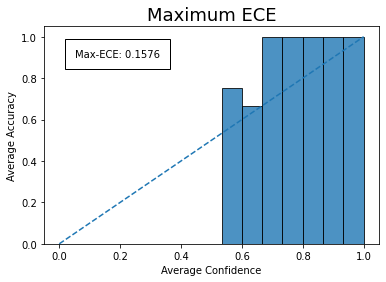

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

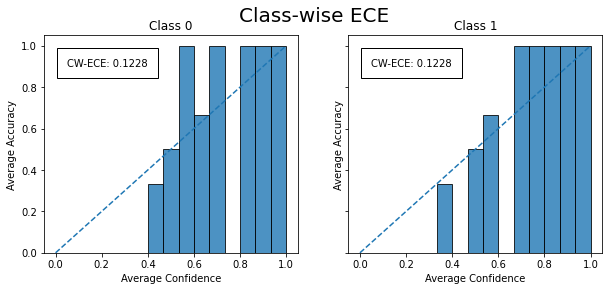

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "Logistic/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/Logistic/


### Naive Bayes

In [ ]:
## Cross validation to train the model
nb = GaussianNB()
nb_cv = model_selection.cross_validate(estimator = nb, X = X_train, y = y_train, scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1 )
#nb.fit(X_train, y_train.ravel())
nb.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GaussianNB()

In [ ]:
## Results from CV
df_metrics = pd.DataFrame({"acc_train_mean" : [nb_cv['train_score'].mean()],
     "acc_train_std" : [nb_cv['train_score'].std()],
     "acc_val_mean" : [nb_cv['test_score'].mean()],
     "acc_val_std" : [nb_cv['test_score'].std()]})

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False)

,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
0,0.829448,0.030143,0.822727,0.057781


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = nb, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = logist_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = logist_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = logist_cv.predict_proba(X_test).argmax(axis = 1))


In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.19944,0.19944,0.28972,0.28972,0.867257,0.878049,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.108410,0.056740,0.024967,0.036
1,Maximum,TV,Uniform,0.090107,0.053378,0.022374,0.067
2,CW,-,Uniform,0.108410,0.426466,0.083474,1.000


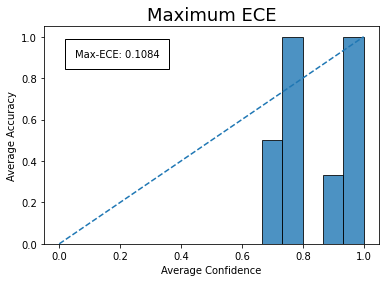

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

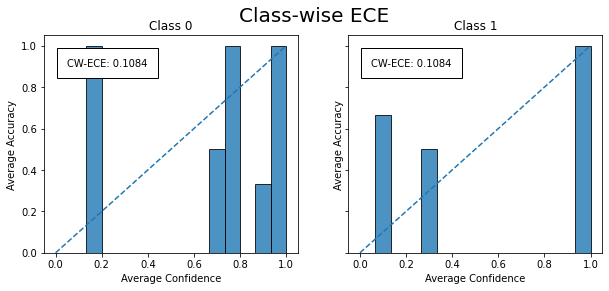

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "NB/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/NB/


### SVM Linear

In [ ]:
## Logistic model
sup = svm.SVC(random_state = 1, probability = True)

## CV fitting
sup_cv = model_selection.GridSearchCV(estimator = sup,
                                     param_grid = {"C" : np.linspace(0.001, 5, 100)}, # 100
                                     scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1, refit = True)

#sup_cv.fit(X_train, y_train.ravel())
sup_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=SVC(probability=True, random_state=1), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 5.14949495e-02, 1.01989899e-01, 1.52484848e-01,
       2.02979798e-01, 2.53474747e-01, 3.03969697e-01, 3.54464646e-01,
       4.04959596e-01, 4.55454545e-01, 5.05949495e-01, 5.56444444e-01,
       6.069393...
       3.83861616e+00, 3.88911111e+00, 3.93960606e+00, 3.99010101e+00,
       4.04059596e+00, 4.09109091e+00, 4.14158586e+00, 4.19208081e+00,
       4.24257576e+00, 4.29307071e+00, 4.34356566e+00, 4.39406061e+00,
       4.44455556e+00, 4.49505051e+00, 4.54554545e+00, 4.59604040e+00,
       4.64653535e+00, 4.69703030e+00, 4.74752525e+00, 4.79802020e+00,
       4.84851515e+00, 4.89901010e+00, 4.94950505e+00, 5.00000000e+00])},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(sup_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = sup_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = sup_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = sup_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = sup_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,C,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
32,1.616838,0.941741,0.005237,0.861681,0.057138
33,1.667333,0.941741,0.005237,0.861681,0.057138
34,1.717828,0.942574,0.005159,0.861681,0.057138
30,1.515848,0.938409,0.005831,0.857977,0.056451
31,1.566343,0.940493,0.004546,0.857977,0.056451


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = sup_cv, nbins = 15, p_value = True, proba = "svm")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = proba_svm(X_train, sup_cv).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = proba_svm(X_val, sup_cv).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = proba_svm(X_test, sup_cv).argmax(axis = 1))

In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.213545,0.213545,0.377689,0.377689,0.933628,0.97561,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.198891,0.271748,0.044012,0.964
1,Maximum,TV,Uniform,0.244220,0.158705,0.047790,0.048
2,CW,-,Uniform,0.244220,0.290665,0.066934,0.752


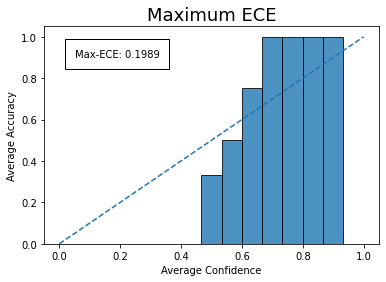

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

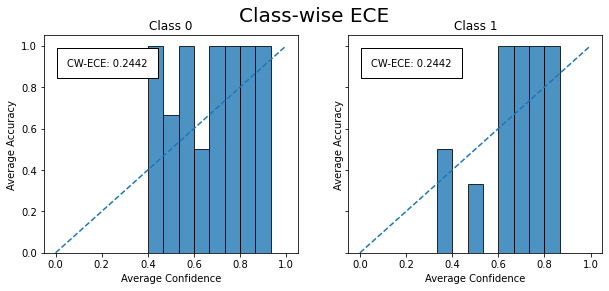

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "SVM-Linear/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/SVM-Linear/


### SVM RBF

In [ ]:
## Logistic model
sup = svm.SVC(random_state = 1, probability = True, kernel = "rbf")

## CV fitting
sup_cv = model_selection.GridSearchCV(estimator = sup,
                                     param_grid = {"C" : np.linspace(0.5, 3, 25), "gamma" : np.linspace(0.01, 1, 25)},
                                     scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1, refit = True)

#sup_cv.fit(X_train, y_train.ravel())
sup_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=SVC(probability=True, random_state=1), n_jobs=-1,
             param_grid={'C': array([0.5       , 0.60416667, 0.70833333, 0.8125    , 0.91666667,
       1.02083333, 1.125     , 1.22916667, 1.33333333, 1.4375    ,
       1.54166667, 1.64583333, 1.75      , 1.85416667, 1.95833333,
       2.0625    , 2.16666667, 2.27083333, 2.375     , 2.47916667,
       2.58333333, 2.6875    , 2.79166667, 2.89583333, 3.        ]),
                         'gamma': array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ])},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(sup_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = sup_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = sup_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = sup_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = sup_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,C,gamma,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
277,1.645833,0.0925,0.934663,0.005305,0.861681,0.057138
302,1.750000,0.0925,0.937994,0.005070,0.861681,0.057138
327,1.854167,0.0925,0.940493,0.005254,0.861681,0.057138
275,1.645833,0.0100,0.866829,0.007040,0.861254,0.047695
352,1.958333,0.0925,0.942159,0.005027,0.857835,0.054089


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = sup_cv, nbins = 15, p_value = True, proba = "svm")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = proba_svm(X_train, sup_cv).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = proba_svm(X_val, sup_cv).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = proba_svm(X_test, sup_cv).argmax(axis = 1))

In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.208703,0.208703,0.371077,0.371077,0.929204,0.95122,0.9


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.183151,0.271017,0.041579,0.992
1,Maximum,TV,Uniform,0.263830,0.157531,0.048183,0.023
2,CW,-,Uniform,0.213512,0.290446,0.067336,0.873


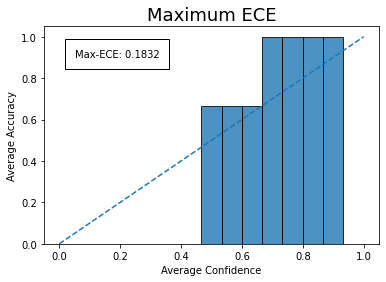

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

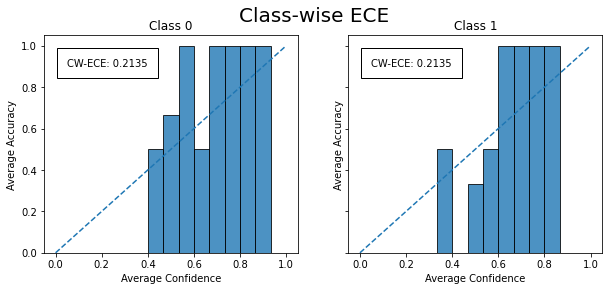

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "SVM-RBF/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/SVM-RBF/


### Random Forest

In [ ]:
#==============================================#
#  Search best parameters for random forests   #
#==============================================#
rf = RandomForestClassifier(random_state = 21)
rf_cv = model_selection.GridSearchCV(estimator = rf, param_grid = {"max_depth" : range(2,50,3), "n_estimators" : range(10, 500, 15) }, scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1 )
#rf_cv.fit(X_train, y_train.ravel())
rf_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=RandomForestClassifier(random_state=21), n_jobs=-1,
             param_grid={'max_depth': range(2, 50, 3),
                         'n_estimators': range(10, 500, 15)},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(rf_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = rf_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = rf_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = rf_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = rf_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,max_depth,n_estimators,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
35,5,40,0.930923,0.006975,0.846581,0.058123
22,2,340,0.866413,0.006114,0.846154,0.052099
28,2,430,0.865581,0.006537,0.846154,0.049177
36,5,55,0.930093,0.007798,0.842735,0.059285
497,47,40,0.999167,0.001667,0.842735,0.056924


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = rf_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = rf_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = rf_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = rf_cv.predict_proba(X_test).argmax(axis = 1))


In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.186803,0.186803,0.321547,0.321547,0.929204,0.902439,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.127699,0.224075,0.039425,0.998
1,Maximum,TV,Uniform,0.194822,0.140279,0.043624,0.112
2,CW,-,Uniform,0.147548,0.335249,0.072800,0.997


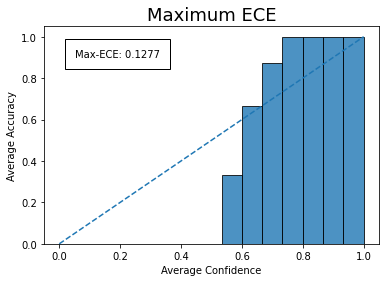

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

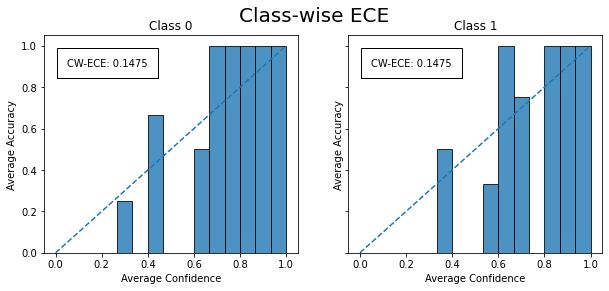

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "Random Forest/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/Random Forest/


### KNN

In [ ]:
## List of parameters to try
p_par = range(2,50,2)
weights_par = ["uniform", "distance"]
n_neighbors_par = range(2, 50, 2)

## Search of best parameters with cross validation
knn = KNeighborsClassifier()
knn_cv = model_selection.GridSearchCV(estimator = knn, param_grid = {"p" : p_par, "weights" : weights_par, "n_neighbors" : n_neighbors_par}, scoring = "accuracy", n_jobs = -1, cv = cv_par, return_train_score = True )
#knn_cv.fit(X_train, y_train)
knn_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50, 2), 'p': range(2, 50, 2),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(knn_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = knn_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = knn_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = knn_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = knn_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,n_neighbors,p,weights,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
96,6,2,uniform,0.867254,0.010534,0.839031,0.066284
241,12,2,distance,1.000000,0.000000,0.835043,0.050792
145,8,2,distance,1.000000,0.000000,0.835043,0.058702
529,24,2,distance,1.000000,0.000000,0.831624,0.040984
240,12,2,uniform,0.848109,0.008322,0.831339,0.048228


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = knn_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = knn_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = knn_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = knn_cv.predict_proba(X_test).argmax(axis = 1))

In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.138889,0.138889,0.238213,0.238213,0.871681,0.878049,0.9


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.094444,0.078428,0.037527,0.300
1,Maximum,TV,Uniform,0.094444,0.077700,0.038753,0.280
2,CW,-,Uniform,0.094444,0.352611,0.083733,0.999


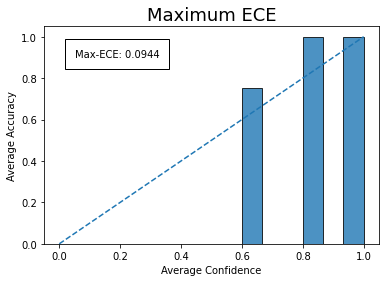

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

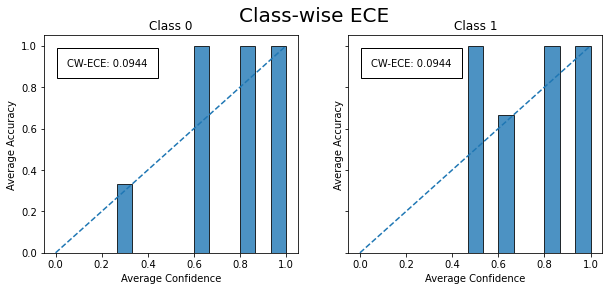

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "KNN/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/KNN/


### Decision trees

In [ ]:
#==============================================#
#  Search best parameters for random forests   #
#==============================================#
dt = DecisionTreeClassifier(random_state = 2210)
dt_cv = model_selection.GridSearchCV(estimator = dt, param_grid = {"max_depth" : range(2,50,3) }, scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1 )
#dt_cv.fit(X_train, y_train.ravel())
dt_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=DecisionTreeClassifier(random_state=2210), n_jobs=-1,
             param_grid={'max_depth': range(2, 50, 3)}, return_train_score=True,
             scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(dt_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = dt_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = dt_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = dt_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = dt_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,max_depth,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
0,2,0.774448,0.011575,0.756553,0.060216
1,5,0.930916,0.007754,0.756125,0.064288
3,11,1.000000,0.000000,0.737749,0.050115
4,14,1.000000,0.000000,0.737749,0.050115
5,17,1.000000,0.000000,0.737749,0.050115


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = dt_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = dt_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = dt_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = dt_cv.predict_proba(X_test).argmax(axis = 1))


In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.277196,0.277196,0.431216,0.431216,0.761062,0.853659,0.7


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.116742,0.116111,0.043906,0.459
1,Maximum,TV,Uniform,0.132189,0.106507,0.045376,0.260
2,CW,-,Uniform,0.132189,0.288171,0.079340,0.972


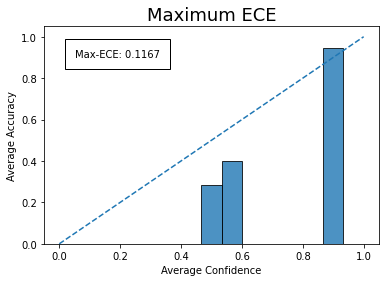

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

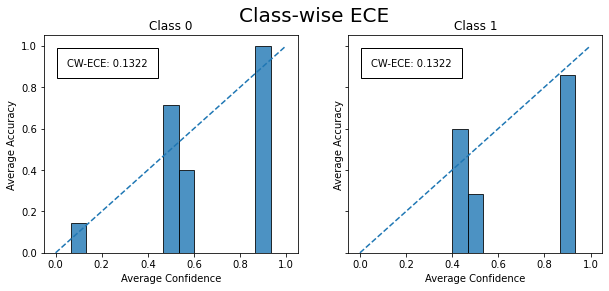

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "Decision Trees/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/Decision Trees/


### MLP 1 Layer

In [ ]:
#==============================================#
#  Search best parameters for random forests   #
#==============================================#
parameters = {"hidden_layer_sizes" : [(16,), (32,), (64,), (128,), (256,), (512,)], "activation" : ["identity","relu"] }

mlp = MLPClassifier(random_state = 2210, solver = "adam", learning_rate_init = 0.001, learning_rate = "adaptive")
mlp_cv = model_selection.GridSearchCV(estimator = mlp, param_grid = parameters, scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1 )
#mlp_cv.fit(X_train, y_train.ravel())
mlp_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=MLPClassifier(learning_rate='adaptive',
                                     random_state=2210),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'relu'],
                         'hidden_layer_sizes': [(16,), (32,), (64,), (128,),
                                                (256,), (512,)]},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(mlp_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = mlp_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = mlp_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = mlp_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = mlp_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,activation,hidden_layer_sizes,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
13,relu,"(32,)",0.909274,0.009144,0.850000,0.047494
1,relu,"(32,)",0.909274,0.009144,0.850000,0.047494
0,relu,"(16,)",0.893053,0.007870,0.842450,0.052669
12,relu,"(16,)",0.893053,0.007870,0.842450,0.052669
7,identity,"(32,)",0.874321,0.007681,0.835185,0.047494


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = mlp_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = mlp_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = mlp_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = mlp_cv.predict_proba(X_test).argmax(axis = 1))


In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.176816,0.176816,0.274972,0.274972,0.90708,0.902439,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.103400,0.162564,0.040731,0.937
1,Maximum,TV,Uniform,0.173252,0.121442,0.036528,0.087
2,CW,-,Uniform,0.121538,0.391477,0.078180,1.000


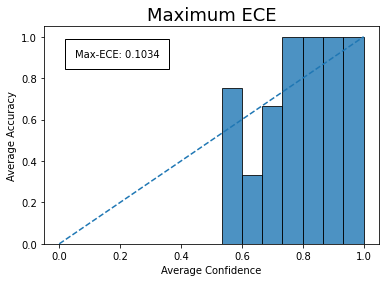

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

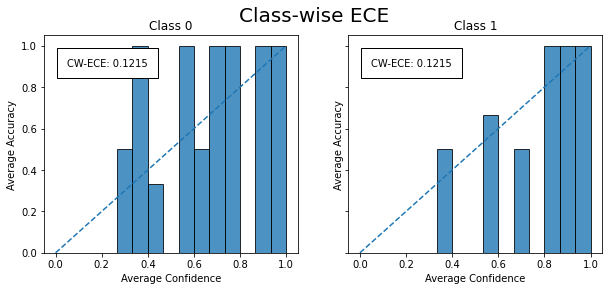

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "MLP 1 Capa/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/MLP 1 Capa/


### MLP 2 Layers

In [ ]:
#==============================================#
#  Search best parameters for random forests   #
#==============================================#
parameters = {"hidden_layer_sizes" : [(16,16),
                                      (32,16),
                                      (64,32), (64,16),
                                      (128,64), (128,32), (128,16),
                                      (256,128), (256,64), (256,32), (256,16)], "activation" : ["identity","relu"] }

mlp = MLPClassifier(random_state = 2210, solver = "adam", learning_rate_init = 0.001, learning_rate = "adaptive")
mlp_cv = model_selection.GridSearchCV(estimator = mlp, param_grid = parameters, scoring = "accuracy", cv = cv_par, return_train_score = True, n_jobs = -1 )
#mlp_cv.fit(X_train, y_train.ravel())
mlp_cv.fit(np.concatenate((X_train, X_val), axis = 0), np.concatenate((y_train.ravel(), y_val.ravel()), axis = 0))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=512),
             estimator=MLPClassifier(learning_rate='adaptive',
                                     random_state=2210),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'relu'],
                         'hidden_layer_sizes': [(16, 16), (32, 16), (64, 32),
                                                (64, 16), (128, 64), (128, 32),
                                                (128, 16), (256, 128),
                                                (256, 64), (256, 32),
                                                (256, 16)]},
             return_train_score=True, scoring='accuracy')

In [ ]:
## Results from CV
df_metrics = pd.DataFrame(mlp_cv.cv_results_["params"])
df_metrics["acc_train_mean"] = mlp_cv.cv_results_['mean_train_score']
df_metrics["acc_train_std"] = mlp_cv.cv_results_['std_train_score']
df_metrics["acc_val_mean"] = mlp_cv.cv_results_['mean_test_score']
df_metrics["acc_val_std"] = mlp_cv.cv_results_['std_test_score']

## Top 5 best results
df_metrics.sort_values(by = "acc_val_mean", ascending = False).head(5)

,activation,hidden_layer_sizes,acc_train_mean,acc_train_std,acc_val_mean,acc_val_std
17,identity,"(128, 16)",0.877237,0.004243,0.831624,0.050027
16,identity,"(128, 32)",0.873076,0.005652,0.831481,0.060228
12,identity,"(32, 16)",0.874732,0.008735,0.831481,0.044512
18,identity,"(256, 128)",0.872241,0.010409,0.831481,0.050725
19,identity,"(256, 64)",0.876817,0.005408,0.831339,0.048005


In [ ]:
## Metrics of calibration
gm, gm_ece, dmax, dcw = resume_metrics(X_test = X_test, Y_test = y_test, T_test = pd.get_dummies(y_test[:,0]).values, model = mlp_cv, nbins = 15, p_value = True, proba = "predict_proba")

## Accuracy metrics
gm["acc_train"] = metrics.accuracy_score(y_true = y_train, y_pred = mlp_cv.predict_proba(X_train).argmax(axis = 1))
gm["acc_val"] = metrics.accuracy_score(y_true = y_val, y_pred = mlp_cv.predict_proba(X_val).argmax(axis = 1))
gm["acc_test"] = metrics.accuracy_score(y_true = y_test, y_pred = mlp_cv.predict_proba(X_test).argmax(axis = 1))


In [ ]:
## Results calibration
gm

,Brier_full,Brier_maximum,Log-loss_full,Log-loss_maximum,acc_train,acc_val,acc_test
0,0.196199,0.196199,0.30988,0.30988,0.880531,0.853659,0.866667


In [ ]:
## Results calibration
gm_ece

,Approach,Distance,Binning,ECE observed,ECE perfcect mean,ECE perfcect std,ECE p-value
0,Maximum,TV,Data,0.097427,0.185230,0.041476,0.991
1,Maximum,TV,Uniform,0.132681,0.133769,0.038388,0.468
2,CW,-,Uniform,0.191653,0.366170,0.077429,0.990


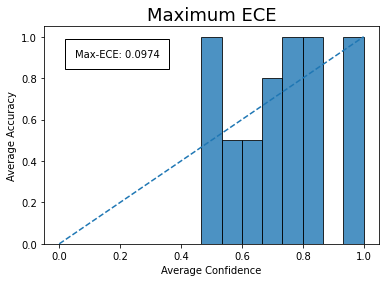

In [ ]:
## Reliability plot for the most confident predictions
ReliabilityDiagram(dmax, diagram = "max", nr_plt = 0, nc_plt = 0, w_plt = 6, h_plt = 4)

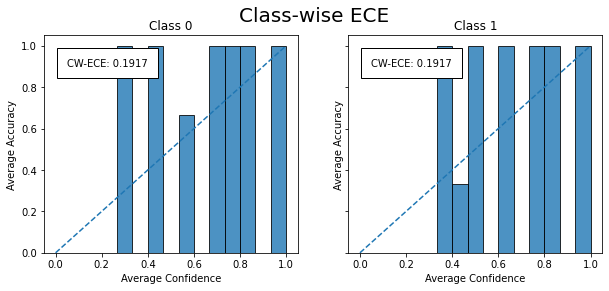

In [ ]:
## Reliability plot for each class
ReliabilityDiagram(dcw, diagram = "cw", nr_plt = 1, nc_plt = 2, w_plt = 10, h_plt = 4)

In [ ]:
## Path to save results
dir_out = dir + "MLP 2 Capa/"

if(not os.path.exists(dir_out)):
  os.mkdir(dir_out)

print(dir_out)

## Export results
df_metrics.to_feather(dir_out + "CVMetrics.feather")
gm.to_feather(dir_out + "GM.feather")
gm_ece.to_feather(dir_out + "GM_ECE.feather")
dmax.to_feather(dir_out + "Diagram_Max.feather")
dcw.to_feather(dir_out + "Diagram_CW.feather")

/content/drive/MyDrive/Trabajo de Grado Maestría/Experimentos Finales/05_Baselines_NoRNA/Heart/MLP 2 Capa/
